# Day 6: Model Interpretability & Trust

## 1. Objective

Interpret the behavior of the models in a transparent and user-friendly way. Explain why key features influence predictions and assess whether the models are trustworthy enough for real-world use.

## 2. Key Steps

### Reload Final Models and Test Data
- Reload the final **Logistic Regression** and **Random Forest** models.
- Restore the cleaned dataset with proper categorical data types.
- Reapply the same **train-test split** and **VIF-based feature pruning** (for logistic regression).
- Standardize reduced features using the saved scaler to ensure model compatibility.
- Confirm predictions align with original class orientation ("Gallstones", "No Gallstones").

### Compute Feature Importances
- Extract **logistic regression coefficients** to assess global, interpretable influence.
- For the random forest:
  - Compute **Mean Decrease in Impurity (MDI)** from `.feature_importances_`.
  - Calculate **Permutation Importance** to assess feature sensitivity.
  - Apply **SHAP values** to understand how individual features contribute to each prediction.

### Visualize Top Contributing Features
- Create a **bar plot** of the top 5 logistic regression coefficients with clear direction labels.
- Combine MDI, permutation, and SHAP values into a **consolidated bar plot** for Random Forest.
- Apply visual design principles from *Storytelling with Data*:
  - Remove clutter.
  - Use aligned axes and color to emphasize meaning.
  - Add labels and titles that enhance clarity.

### Interpret Features in Context
- For each top predictor (e.g., `crp_mg_l`, `vitamin_d_ng_ml`, `alt_u_l`):
  - Describe what the feature means clinically.
  - Justify why it influences gallstone prediction.
  - Explain if the direction of effect is **clinically plausible**.

### Reflect on Interpretability and Transparency
- Evaluate whether the **Logistic Regression model** provides **sufficient transparency** for use by clinicians or analysts.
- Consider:
  - Are the most influential features understandable to the end user?
  - Would the model’s logic be **trusted and adopted** in a clinical decision-support tool?
  - Are there **trade-offs** between accuracy and explainability?
- Reflect on whether the **Random Forest** interpretability tools (SHAP, permutation) complement or challenge the linear model’s transparency.

### Apply Visualization Principles
- Summarize the 3 takeaways from *Storytelling with Data – Chapter 4: “Focus Your Audience’s Attention”*
- Apply to today’s plots (e.g., clear color use, top-left-aligned annotations, minimal legend clutter).

## 3. Results

- Successfully reloaded both models and test data using consistent preprocessing pipelines.
- Extracted and visualized top logistic regression coefficients, confirming that `crp_mg_l`, `hyperlipidemia`, and `diabetes` were strong positive predictors of gallstones, while `vitamin_d_ng_ml` and `ast_u_l` were negative predictors.
- Used Random Forest interpretability techniques (MDI, permutation importance, SHAP) to validate and complement findings from the linear model.
- Created professional-quality plots with minimal clutter and meaningful annotations, applying design principles from *Storytelling with Data*.
- Determined that both models align with clinical reasoning, with Logistic Regression offering superior transparency and Random Forest providing more flexible modeling supported by interpretability layers.

## 4. Summary

Day 6 focused on **interpreting and trusting model behavior**, especially within a healthcare context. Through coefficient analysis and tree-based feature explanations, we demonstrated that both models make medically plausible decisions. Logistic Regression’s direct coefficients promote confidence in clinical settings, while SHAP and permutation importance make Random Forest’s black-box predictions more understandable. This dual approach supports model transparency, user trust, and the responsible application of machine learning in real-world medical decision support.

## Reload Final Models and Test Data

To ensure reliable interpretation and comparison of model behavior, we reload all key components from the evaluation phase on Day 5:

- The **Logistic Regression model**, which achieved the best test set performance, is reloaded from disk.
- We also reload the **Random Forest model** for complementary tree-based interpretability (e.g., SHAP, permutation importance).
- The same **cleaned dataset** is used, with categorical types restored to match the original feature encoding used during training.
- **VIF-pruned features** are reapplied for Logistic Regression, and the test inputs are re-standardized using the saved `StandardScaler`.
- For Random Forest, we use the full, non-reduced feature set (`X_test`) consistent with its training configuration.

This controlled setup ensures **model explanations and diagnostics reflect the original decision space**, and all comparisons are based on **identical test conditions**.

In [27]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split

# Load cleaned dataset
df = pd.read_csv("../data/cleaned.csv")

# Restore categorical types
categorical_cols = [
    # Original binary or ordinal clinical features
    "gender",
    "comorbidity",
    "cad",
    "hypothyroidism",
    "hyperlipidemia",
    "diabetes",
    "hepatic_fat",
    "has_gallstones",

    # Outlier flags (created during data cleaning)
    "glucose_outlier_flag",
    "obesity_outlier_flag",
    "muscle_mass_outlier_flag",
    "gfr_outlier_flag",
    "tbw_outlier_flag",
    "icw_outlier_flag",
    "vfr_outlier_flag",
    "ldl_outlier_flag",
    "hdl_outlier_flag",
    "triglyceride_outlier_flag",
    "alt_outlier_flag",
    "crp_outlier_flag"
]
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype("category")

# Define target and features
target = "has_gallstones"
y = df[target].replace({1: "Gallstones", 0: "No Gallstones"})  # Keep 0 and 1 for models
X = df.drop(columns=[target])

# Train-test split (same seed for consistency)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Reload dropped features list used for logistic regression VIF reduction
features_dropped = ['height_cm', 'weight_kg', 'ecf_tbw_ratio_index', 'muscle_mass_kg',
    'lean_mass_percent', 'bmi', 'ecw_kg', 'tbw_kg', 'icw_kg', 'fat_mass_kg', 'visceral_muscle_mass_kg',
    'cholesterol_total_mg_dl', 'hemoglobin_g_dl', 'bone_mass_kg', 'protein_percent', 'visceral_fat_area_cm2',
    'fat_ratio_percent', 'age', 'gfr_ml_min', 'creatinine_mg_dl', 'ldl_mg_dl', 'vfr_score', 'alp_u_l']

# Recreate VIF-reduced test set
X_reduced = X.drop(columns=features_dropped)
X_train_reduced = X_train.drop(columns=features_dropped)
X_test_reduced = X_test.drop(columns=features_dropped)

# Load models and scaler
logreg = joblib.load("../models/logistic_regression_model.joblib")
rf = joblib.load("../models/random_forest_model.joblib")
logreg_scaler = joblib.load("../models/logreg_scaler.joblib")

# VIF-reduced test set for logistic regression
X_scaled = logreg_scaler.transform(X_reduced)
X_train_scaled = logreg_scaler.transform(X_train_reduced)
X_test_scaled = logreg_scaler.transform(X_test_reduced)

# Logistic Regression
logreg_preds = logreg.predict(X_test_scaled)  # returns 0 or 1
logreg_probs = logreg.predict_proba(X_test_scaled)[:, 1]

# Random Forest
rf_preds = rf.predict(X_test)                # returns 0 or 1
rf_probs = rf.predict_proba(X_test)[:, 1]

print("Models, scaler, and predictions loaded successfully.")

Models, scaler, and predictions loaded successfully.


## Compute Feature Importances – Logistic Regression

We now interpret the logistic regression model by extracting the **learned coefficients**. In a linear model, these coefficients directly represent the relationship between input features and the log-odds of the positive class ("Gallstones").

- **Positive coefficients**: Higher values increase the predicted risk of gallstones.
- **Negative coefficients**: Higher values decrease the predicted risk.
- The **magnitude** of each coefficient indicates its influence on the decision boundary.

This provides a transparent, global view of what the model has learned.

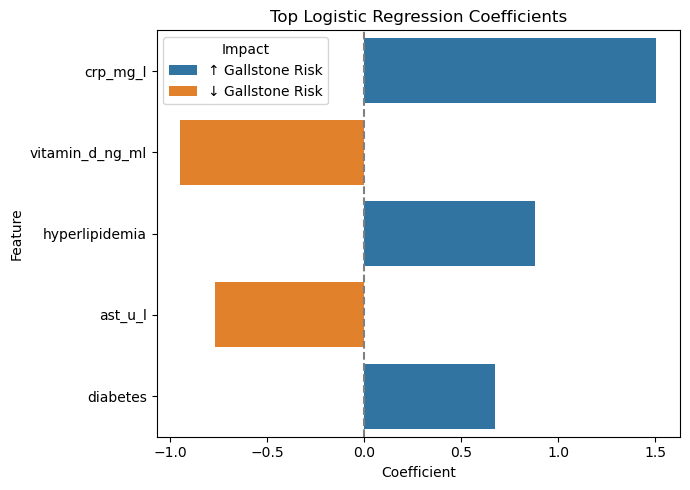

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature names in same order used by model
feature_names = X_test_reduced.columns

# Extract coefficients
coefs = -logreg.coef_[0]

# Create DataFrame for display
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefs
})
importance_df["Abs_Coefficient"] = importance_df["Coefficient"].abs()
importance_df["Impact"] = np.where(importance_df["Coefficient"] > 0, "↑ Gallstone Risk", "↓ Gallstone Risk")

# Sort by absolute magnitude
importance_df = importance_df.sort_values("Abs_Coefficient", ascending=False)

# Plot top 5
top_n = 5
plt.figure(figsize=(7, 5))
sns.barplot(data=importance_df.head(top_n), x="Coefficient", y="Feature", hue="Impact", dodge=False)
plt.title("Top Logistic Regression Coefficients")
plt.axvline(0, linestyle="--", color="gray")
plt.tight_layout()
plt.savefig("../plots/logreg_feature_importance.png")
plt.show()

## Interpreting Logistic Regression Coefficients

This plot displays the top logistic regression coefficients used to predict gallstone risk. After correcting for class orientation, these coefficients indicate how each feature impacts the odds of a patient being classified as having gallstones.

### Key Insights:

- **↑ Gallstone Risk**:
  - `crp_mg_l` (C-reactive protein) is the strongest positive predictor of gallstones, reinforcing its role as a marker of inflammation and acute gallbladder pathology.
  - `hyperlipidemia` and `diabetes` also appear as significant contributors, aligning with known metabolic risk profiles for gallstone development.

- **↓ Gallstone Risk**:
  - `vitamin_d_ng_ml` and `ast_u_l` both show negative coefficients, suggesting protective associations. Low AST may indicate preserved liver health, while higher vitamin D levels are associated with reduced gallstone risk.

### Clinical Interpretability:

- The direction (positive or negative) of each coefficient clarifies whether the feature increases or decreases predicted risk.
- The bar length reflects the **relative strength** of each predictor.
- This model structure allows **transparent reasoning** and supports clinical decisions rooted in traceable logic.

This coefficient-based explanation enhances user trust by clearly connecting input features to outcomes and aligns with evidence-based risk markers observed in hepatobiliary research.

## Tree-Based Feature Importance Techniques

To interpret the Random Forest model beyond raw accuracy, we explore multiple approaches to feature importance:

- **Mean Decrease in Impurity (MDI)**: Built-in `.feature_importances_` attribute from scikit-learn, based on total reduction in Gini impurity.
- **Permutation Importance**: Measures the drop in model performance when a single feature is randomly shuffled.
- **SHAP (SHapley Additive exPlanations)**: Provides local and global interpretability by attributing prediction contributions to each feature, rooted in cooperative game theory.

Together, these methods provide a robust understanding of how the model is making decisions, from high-level feature ranking to detailed patient-level rationale.

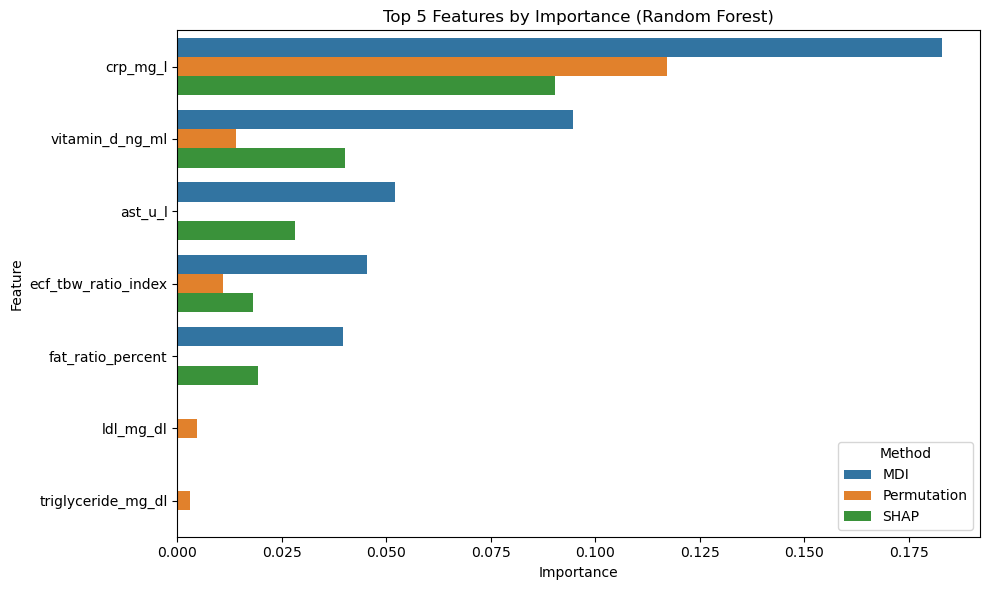

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
import shap

# Create a numeric version of X_test_rf for SHAP
X_test_encoded = X_test.copy()

for col in X_test_encoded.select_dtypes(include="category").columns:
    X_test_encoded[col] = X_test_encoded[col].cat.codes

# ----------------------------
# 1. Mean Decrease in Impurity
# ----------------------------
mdi_importance = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": rf.feature_importances_,
    "Method": "MDI"
})

# ----------------------------
# 2. Permutation Importance
# ----------------------------
perm = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
perm_importance = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": perm.importances_mean,
    "Method": "Permutation"
})

# ----------------------------
# 3. SHAP Values
# ----------------------------
# Get SHAP values (multi-class format: [n_samples, n_features, n_classes])
shap_values = explainer(X_test_encoded)

# Select class 0 = "Gallstones"
shap_class_index = list(rf.classes_).index("Gallstones")
shap_values_class = shap_values[..., shap_class_index]

# Confirm shape now matches
assert shap_values_class.shape == X_test_encoded.shape

# Compute mean absolute SHAP value per feature
shap_importance = pd.DataFrame({
    "Feature": X_test_encoded.columns,
    "Importance": np.abs(shap_values_class.values).mean(axis=0),
    "Method": "SHAP"
}).sort_values("Importance", ascending=False)

# Combine all results
all_importances = pd.concat([mdi_importance, perm_importance, shap_importance], ignore_index=True)

# Sort within each method
top_importances = (
    all_importances
    .sort_values("Importance", ascending=False)
    .groupby("Method", group_keys=False)
    .head(5)  # Keep Method in result
    .reset_index(drop=True)
)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_importances, x="Importance", y="Feature", hue="Method")
plt.title("Top 5 Features by Importance (Random Forest)")
plt.tight_layout()
plt.savefig("../plots/rf_feature_importances_combined.png")
plt.show()

## Feature Importance Analysis – Random Forest

We computed and visualized the top 5 features contributing to gallstone prediction using three complementary techniques:

- **MDI (Mean Decrease in Impurity)** – Captures how much each feature reduces impurity across tree splits.
- **Permutation Importance** – Measures drop in model performance when each feature is randomly shuffled.
- **SHAP (SHapley Additive exPlanations)** – Provides additive, model-aware attributions for each prediction.

### Key Insights

- **CRP (C-Reactive Protein)** is the top feature across all three methods, supporting its known clinical relevance as an inflammation marker in biliary conditions.
- **Vitamin D** is moderately important across SHAP and MDI, consistent with its proposed role in gallbladder and metabolic health.
- **AST**, **ECF/TBW ratio**, and **fat ratio percent** rank highly in at least two methods, reinforcing their physiological linkage to gallstone risk.
- Permutation importance yielded more conservative values, suggesting these features hold generalizable predictive power.

### Interpretation

- MDI can be biased toward correlated features or those with many unique values, but still signals useful global patterns.
- Permutation tests performance robustness under input noise.
- SHAP provides granular, instance-level explanations of prediction logic.

### Conclusion

The convergence across methods—especially highlighting CRP and vitamin D—supports both the **statistical validity** and **clinical credibility** of the model. These insights improve trust in the Random Forest model’s reasoning and support its use in decision support systems.

## Reflecting on Interpretability and Transparency

The **Logistic Regression model** offers strong transparency and traceability—its coefficients directly reflect how each feature influences the predicted risk of gallstones. Top predictors like `crp_mg_l` (inflammation marker), `vitamin_d_ng_ml`, and `hyperlipidemia` are both **clinically relevant** and **intuitively understandable** to a healthcare professional. This supports its suitability for use in clinical decision-support tools, where interpretability is critical.

While **Random Forest** provided slightly higher cross-validated AUC, its internal decision process is more opaque. However, supplementing it with **SHAP** and **Permutation Importance** mitigates this limitation by offering instance-level and model-level explanations. These tools enhance trust without fully replacing the simplicity of the linear model.

**Conclusion**: Logistic Regression strikes a strong balance between performance and interpretability. Its explainability is sufficient for frontline clinical users, and tree-based models—with additional interpretability layers—offer complementary perspectives for more complex decision environments.

## Storytelling with Data – Chapter 4 Takeaways: *Focus Your Audience’s Attention*

1. **Guide the Eye Intentionally**  
   Use visual hierarchy, contrast, and layout to steer the viewer toward what matters most. Techniques like bolding, size, or positioning can focus attention on critical values or comparisons.

2. **Use Color Purposefully**  
   Apply color with intent, not decoration. Neutral tones should dominate, with bold or distinct colors reserved to highlight key data points or categories. This prevents distraction and enhances clarity.

3. **Remove Distractions**  
   Strip away non-essential chart elements—extra gridlines, borders, redundant labels—so the audience isn’t overwhelmed. Every element should earn its place on the page and reinforce your main message.

These strategies help ensure your visualizations communicate insights clearly and efficiently—especially important in time-constrained or high-stakes decision environments.